In [1]:
import pandas as pd
import sys
if sys.version_info[0] < 3: 
    from StringIO import StringIO
else:
    from io import StringIO
from itertools import islice
import re
import matplotlib.pyplot as plt
import tikzplotlib


def find_matching_lines(file, string):
    curLineNum=0
    lineNums=[];
    with open (file, "r") as myfile:
        for line in myfile:
            if string in line:
                lineNums.append(curLineNum)
            curLineNum = curLineNum+1

    lineNums.append(curLineNum+1)
    return lineNums
                
def pandas_read_range(file, start_linenum, end_linenum):
    df = pd.read_csv(file, skiprows=start_linenum+1, nrows=(end_linenum-start_linenum)-1) #-1 since header is not included here
    fp = open(file)
    for i, line in enumerate(fp):
        if i == start_linenum:
            header_dict=parseHeader(line)
    fp.close()
    return (header_dict, df)
            
def parseHeader(line):
    header = re.split(',', line)
    header_num_keys = len(header)
    header_keys=[]
    header_vals=[]
    for key_id in range(0, header_num_keys):
        cur_header_key = re.split('=', header[key_id])
        header_keys.append(cur_header_key[0].rstrip().lstrip())
        header_vals.append(cur_header_key[1].rstrip().lstrip())

    header_dict=dict(zip(header_keys, header_vals))
    return  header_dict

def findMatchHeaderIds(headers, headerFilter):
    matchedIdx=[]
    numHeaders=len(headers)
    for i in range(numHeaders):
        headerSet = set(headers[i])
        filterSet = set(headerFilter)
        allFilterTrue=True
        for name in headerSet.intersection(filterSet):
            #print(headers[i][name])
            pattern = re.compile(headerFilter[name])
            #pattern.match(string)
            if(bool(pattern.match(headers[i][name]))==False): #(headers[i][name] != headerFilter[name]):
                allFilterTrue=False
        if(allFilterTrue):
            matchedIdx.append(i)
    return matchedIdx

def createLegends(legendKeys, headerDict): #headerDict, filterDict):
    #headerSet = set(headerDict)
    #filterSet = set(filterDict)
    #legendKeys = list(headerSet ^ filterSet)
    legendStr = ""
    for el in legendKeys:
        legendStr+=el+"="+headerDict[el]+", "
    #print(legendStr)
    return legendStr.rstrip(', ')
    

def createPlot(axs, dfs, df_main_header_strings, xFeature, yFeature, legendKeys, headerFilter, tikzFileName):
    #Now plot
    #xFeature="Iter"
    #yFeature="errNorm"
    #legendKeys=["Matrix", "Precon subtype", "Polynomial Degree"]
    #set filters
    #headerFilter = {'Matrix': 'af_shell10', 'Precon type': 'RELAXATION', 'Threads': '20', 'Polynomial Degree': '40|80'}
    matchedIdx=findMatchHeaderIds(df_main_header_strings, headerFilter)
    #print(matchedIdx)
    legendStrs=[]
    for i in matchedIdx:
        #dfs[i].plot(x=xFeature,y=yFeature, style='.-', ax=axs)
        axs.plot(dfs[i][xFeature], dfs[i][yFeature], '.-')
        legendStrs.append(createLegends(legendKeys, df_main_header_strings[i])) #df_main_header_strings[i], headerFilter))
        #tikzplotlib.save(tikzFileName)
    axs.set_xlabel(xFeature, fontsize=16)
    axs.set_ylabel(yFeature, fontsize=16)
    #axs.legend(legendStrs)
    axs.legend("", frameon=False)
    return legendStrs
    #axs.legend(legendStrs, bbox_to_anchor=(1.0, 1.0))

       


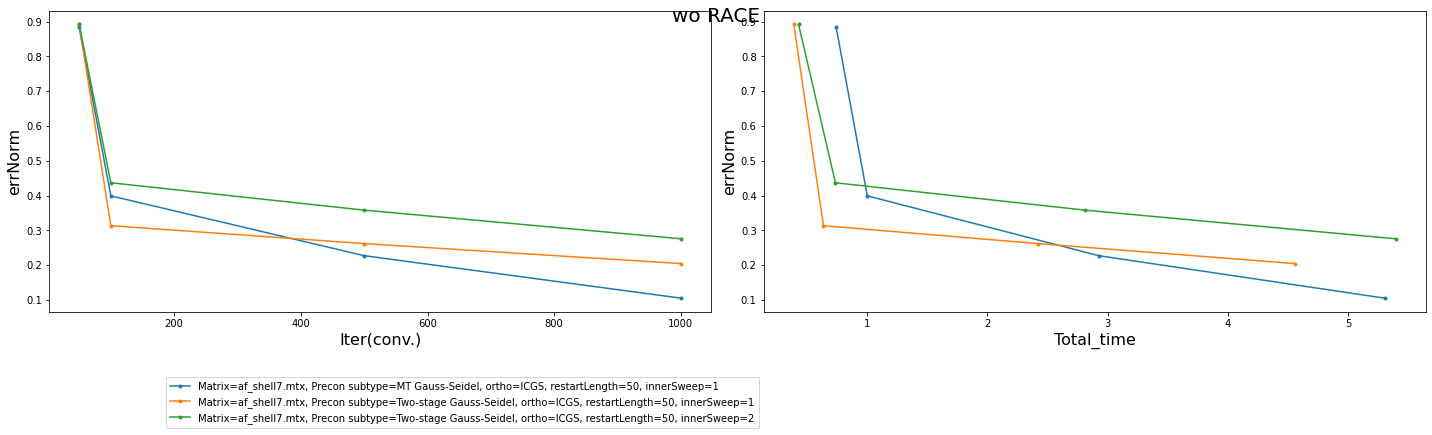

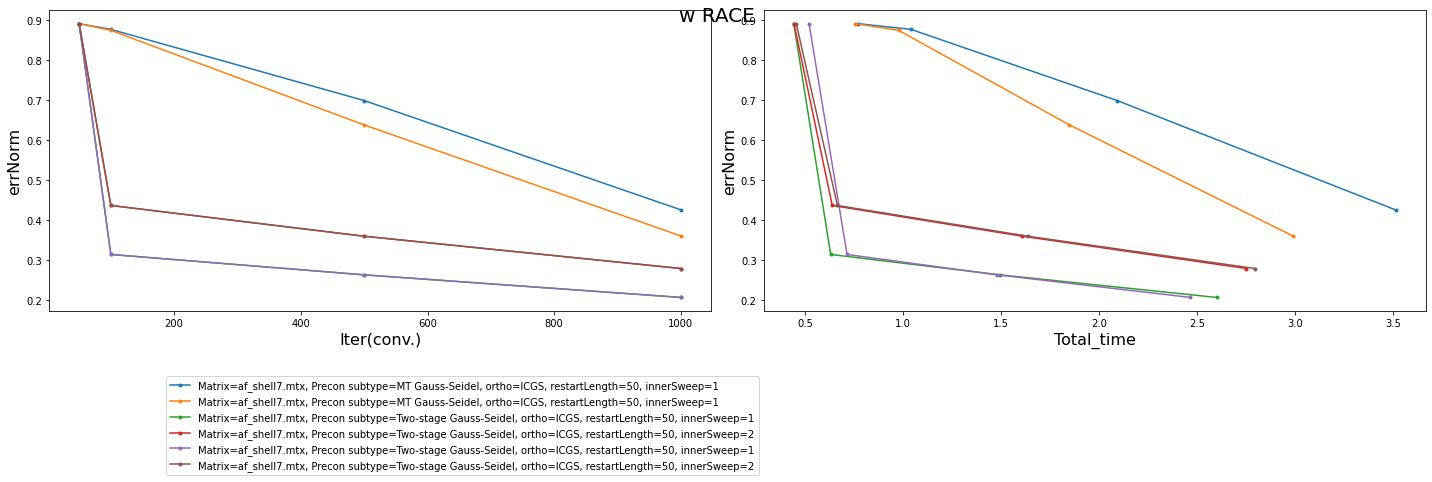

In [12]:
matrix="af_shell7"
machine="horeka"
file_wo_RACE="/Users/ud15idid/MPK_iterative_solvers/plots/"+machine+"/gmres_s_step_results/12_Aug_2022/"+matrix+".txt"
file_w_RACE="/Users/ud15idid/MPK_iterative_solvers/plots/"+machine+"/gmres_s_step_results_w_RACE/12_Aug_2022/"+matrix+".txt"

files=[file_wo_RACE, file_w_RACE]
titles=["wo RACE", "w RACE"]
tikzFileNames=[matrix+"_wo_RACE.tex", matrix+"_w_RACE.tex"]
ctr=0
for file in files:
    matchLineNums=find_matching_lines(file, "Matrix=")
    #print(matchLineNums)
    numMatches=len(matchLineNums)

    dfs=[]
    df_main_header_strings=[]

    for i in range(1,numMatches):
        (header, df) = pandas_read_range(file, matchLineNums[i-1], matchLineNums[i]-1)
        dfs.append(df)
        df_main_header_strings.append(header)


    #print(df_main_header_strings[20]['Matrix'])

    #df = pd.read_csv(file)
    #df.head(100)
    dfs[0].head()

    legendKeys=["Matrix", "Precon subtype", "ortho", 'restartLength', "innerSweep"]
    #set filters
    headerFilter = {'Matrix': matrix, 'Precon type': 'RELAXATION', 'Precon subtype': '.*Gauss-Seidel', 'Threads': '38', 'restartLength': '.*', 'solverType': '^TPETRA GMRES S-STEP$', 'power': '.*'}

    #add totalTime to dfs
    for df in dfs:
        df['Total_time'] = df['Solve_time']+df['Precon_setup'] #+df['RACE_setup']
        if 'RACE_setup' in df.columns:
            df['Total_time'] += df['RACE_setup']

    #study convergence and performance
    #xFeatures=["Iter(conv.)", "Total_time"]
    xFeatures=["Iter(conv.)", "Total_time"] 
    #yFeatures=["resNorm/bNorm", "errNorm"]
    yFeatures=["errNorm"]
    xFeatureSize=len(xFeatures)
    yFeatureSize=len(yFeatures)
    fig, axs = plt.subplots(1, xFeatureSize*yFeatureSize, figsize=(20, 5))
    for i in range(xFeatureSize):
        for j in range(yFeatureSize):
            legendStr=createPlot(axs[i*yFeatureSize+j], dfs, df_main_header_strings, xFeatures[i], yFeatures[j], legendKeys, headerFilter, tikzFileNames[ctr])
            #axs[i*yFeatureSize+j].set_ylim([0, 1e-9])

    fig.tight_layout()
    fig.suptitle(titles[ctr], fontsize=20)
    plt.legend(legendStr, bbox_to_anchor=(0, -0.2))
    plt.show()
    ctr=ctr+1

In [3]:
import glob, os
matrixNames=[]
machine="horeka"
folder="/Users/ud15idid/PhD_Thesis_CA/data/Trilinos_GMRES/"+machine+"/paramStudy_results/28_March_2022/"

os.chdir(folder)

for file in glob.glob("*.txt"):
    matrix=os.path.splitext(file)[0]
    matrixNames.append(matrix)
        
print(matrixNames)
os.chdir("/Users/ud15idid/PhD_Thesis_CA/data/Trilinos_GMRES")

['F1', 'parabolic_fem', 'FreeBosonChain-18', 'HPCG-128-128-128', 'Geo_1438', 'FEM_3D_thermal2', 'af_shell10', 'Emilia_923', 'Transport', 'G3_circuit', 'ldoor', 'dielFilterV3real', 'ML_Geer', 'thermal2']


F1
chosen index  2
projected err  [0.575686   0.43501302 0.2826285 ]


NameError: name 'curRanking' is not defined

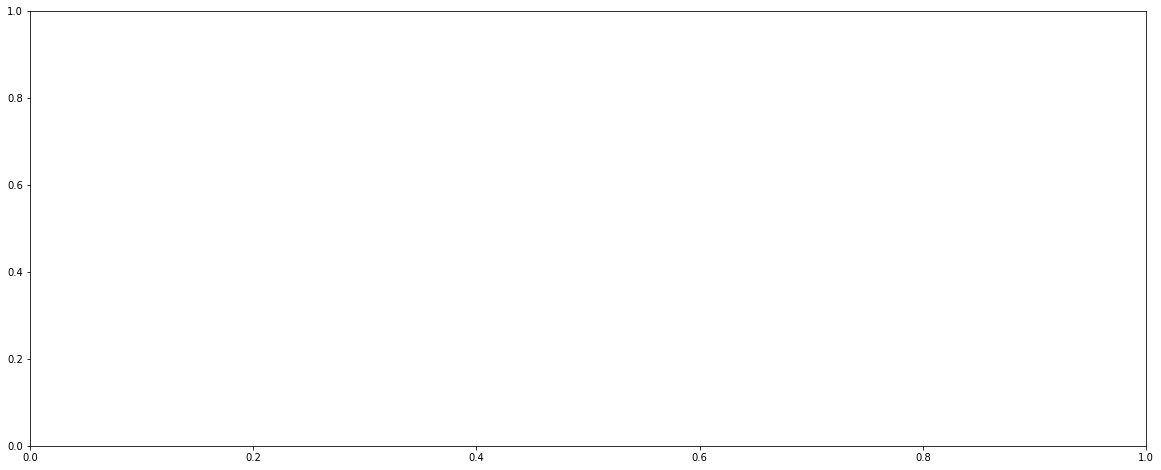

In [28]:

import operator
import numpy as np

#plot for all matrix
machine="horeka"
folder_wo_RACE="/Users/ud15idid/PhD_Thesis_CA/data/Trilinos_GMRES/"+machine+"/paramStudy_results/28_March_2022/"
folder_w_RACE="/Users/ud15idid/PhD_Thesis_CA/data/Trilinos_GMRES/"+machine+"/paramStudy_results_w_RACE/28_March_2022/"

folders=[folder_wo_RACE, folder_w_RACE]
titles=["wo RACE", "w RACE"]
tikzFileNames=["Gmres_allMatrices_wo_RACE.tex", "Gmres_allMatrices_w_RACE.tex"]
ctr=0

#matrices=['F1', 'parabolic_fem', 'FreeBosonChain-18', 'HPCG-128-128-128', 'Geo_1438', 'FEM_3D_thermal2', 'af_shell10', 'Emilia_923', 'Transport', 'G3_circuit', 'ldoor', 'dielFilterV3real', 'ML_Geer', 'thermal2']
#matrices=['F1', 'parabolic_fem', 'HPCG-128-128-128', 'Geo_1438', 'FEM_3D_thermal2', 'af_shell10', 'Emilia_923', 'Transport', 'G3_circuit', 'ldoor', 'ML_Geer', 'thermal2']
matrices=['F1', 'parabolic_fem', 'Geo_1438', 'af_shell10', 'Emilia_923', 'Transport', 'G3_circuit', 'ldoor', 'ML_Geer', 'thermal2']
#matrices=['ML_Geer']
#study convergence and performance
xFeature=["Matrix"]
fixedFeature={'Iter':(operator.eq,5000)} #only one feature allowed
#fixedFeature={'Iter':(operator.eq,5000), 'errNorm':(operator.le,1e-12)}
#yFeature=('errNorm', 'min') #the column and the reduction operator
#yFeature="Total_time" #the column to plot
yFeature="errNorm"
#best configuration is chosen depending on min. value of err*Solve_time 
#Note: not Total_time, because pre-processing overhead decreases with high iterations 

legendKeys=["Matrix", "Precon subtype", "ortho", 'restartLength']
#set filters
headerFilter = {'Precon type': '.*', 'Precon subtype': 'NONE', 'Threads': '38', 'restartLength': '.*', 'solverType': 'TPETRA GMRES S-STEP'}

fig, axs = plt.subplots(figsize=(20, 8))
legends=['w/o RACE', 'RACE']
ctr=0

all_yData=[]
for folder in folders:
    yData=[]
    
    matrices_w_data=[]
    #matrixNames=[]
    #find result files for matrices
    #os.chdir(folder)
    for matrix in matrices:
        print(matrix)
        file=folder+matrix+".txt"
        #matrix=os.path.splitext(file)[0]
        #matrixNames.append(matrix)
        matchLineNums=find_matching_lines(file, "Matrix=")
        #print(matchLineNums)
        numMatches=len(matchLineNums)

        dfs=[]
        df_main_header_strings=[]

        for i in range(1,numMatches):
            (header, df) = pandas_read_range(file, matchLineNums[i-1], matchLineNums[i]-1)
            dfs.append(df)
            df_main_header_strings.append(header)


        #print(df_main_header_strings[20]['Matrix'])

        #df = pd.read_csv(file)
        #df.head(100)
        #dfs[0].head()


        locCtr=0
        #add totalTime to dfs
        for df in dfs:
            df['Total_time'] = df['Solve_time']+df['Precon_setup'] #+df['RACE_setup']
            if 'RACE_setup' in df.columns:
                df['Total_time'] += df['RACE_setup']
            df['err_time_slope'] = df['errNorm'].diff()/df['Solve_time'].diff() #ranking cirteria
            #print(df['ranking_slope'])
            #print(df_main_header_strings[locCtr])
            locCtr+=1

        #now filter based on header
        matchedIdx=findMatchHeaderIds(df_main_header_strings, headerFilter);
        
            
        #now get required value from df based on the fixedFeature criteria and yFeature
        #for df in dfs:
        #    df['']
        #print(dfs[0].head())
#         fig, axs = plt.subplots(1, xFeatureSize*yFeatureSize, figsize=(20, 5))
#         for i in range(xFeatureSize):
#             for j in range(yFeatureSize):
#                 legendStr=createPlot(axs[i*yFeatureSize+j], dfs, df_main_header_strings, xFeatures[i], yFeatures[j], legendKeys, headerFilter, tikzFileNames[ctr])


#         fig.tight_layout()
#         fig.suptitle(titles[ctr], fontsize=20)
#         plt.legend(legendStr, bbox_to_anchor=(0, -0.2))
#         plt.show()
#         ctr=ctr+1
        curYVals=[]
        curSolveTime=[]
        curSlope=[]
        curConst=[]
        curRestartLength=[]
        #filter feature depending on fixedFeature and yFeature
        for feature in fixedFeature:
            featureOp=fixedFeature[feature][0]
            featureVal=fixedFeature[feature][1]

            for i in matchedIdx:
                df=dfs[i]
                #print(df.head())
                filteredDf = df[featureOp(df[feature],featureVal)]
                #print(filteredDf.head())
                yFeatureOp=yFeature[1]
                #if yFeatureOp=='min':
                curSlope.extend(filteredDf['err_time_slope'].values) #apply reduction operator
                curYVals.extend(filteredDf[yFeature].values)
                curConst.extend(filteredDf['errNorm']-filteredDf['err_time_slope']*filteredDf['Solve_time']) #y0-m*x0
                curSolveTime.extend(filteredDf['Solve_time'].values)
                #else:
                #    curYVals.append(filteredDf['ranking'].max()) #apply reduction operator

        if curYVals:
            #if yFeatureOp=='min':
            minTime=np.min(np.array(curSolveTime))
            #find the min error at the min. possible solve time
            err = np.array(curSlope)*minTime+np.array(curConst)
            minErrIndex = np.argmin(err)
            print("chosen index ", minErrIndex)
            print("projected err ", err)
            print("chosen rank ", curRanking[minErrIndex])
            print("chosen setting ", df_main_header_strings[matchedIdx[minErrIndex]])
            print("chosen yValue ", curYVals[minErrIndex])
            yData.append(curYVals[minErrIndex])
            #else:
            #    yData.append(max(curYVals))
            matrices_w_data.append(matrix)

    print(yData)
    all_yData.append(yData)
    #plt.plot(matrices_w_data, yData, '.-', label=legends[ctr])
    ctr=ctr+1

#yToPlot=np.array(all_yData[0])/np.array(all_yData[1])
yToPlot=np.array(all_yData[0])
print("Average y value = ", np.average(yToPlot))
plt.plot(matrices_w_data, yToPlot, '.-', label="Speedup")
#plt.plot(matrices_w_data, (np.array(all_yData[0])), '.-', label="Error norm")
tikzplotlib.save("gmres_speedup.tex")
    
axs.set_xlabel("Matrix", fontsize=16)
#axs.set_ylabel("Time (s)", fontsize=16)
axs.set_ylabel("Speedup", fontsize=16)

#axs.set_ylabel("Error norm", fontsize=16)
axs.legend()
plt.xticks(matrices_w_data, rotation=90);
axs.set_ylim([0, 1.8])


F1
chosen index  0
projected err  [9.07999e-08]
chosen setting  {'Matrix': 'F1.mtx', 'Threads': '38', 'Precon type': 'RILUK', 'Precon subtype': '1', 'ortho': 'ICGS', 'restartLength': '100', 'solverType': 'TPETRA GMRES S-STEP'}
chosen yValue  50.88
parabolic_fem
chosen index  0
projected err  [nan]
chosen setting  {'Matrix': 'parabolic_fem.mtx', 'Threads': '38', 'Precon type': 'RILUK', 'Precon subtype': '1', 'ortho': 'ICGS', 'restartLength': '100', 'solverType': 'TPETRA GMRES S-STEP'}
chosen yValue  nan
Geo_1438
chosen index  0
projected err  [1.43201e-07]
chosen setting  {'Matrix': 'Geo_1438.mtx', 'Threads': '38', 'Precon type': 'RILUK', 'Precon subtype': '1', 'ortho': 'ICGS', 'restartLength': '50', 'solverType': 'TPETRA GMRES S-STEP'}
chosen yValue  18.936
Transport
chosen index  0
projected err  [8.90991e-07]
chosen setting  {'Matrix': 'Transport.mtx', 'Threads': '38', 'Precon type': 'RILUK', 'Precon subtype': '1', 'ortho': 'ICGS', 'restartLength': '100', 'solverType': 'TPETRA GMRES 

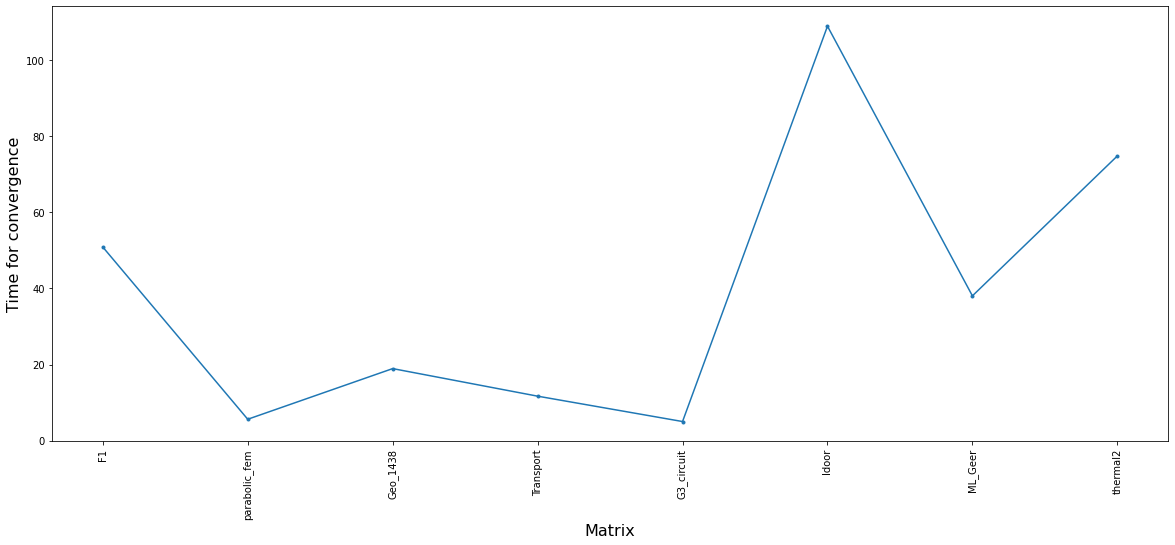

In [66]:
#plot based on parameters
#best of RACE and woRACE

import operator
import math
import numpy as np

#plot for all matrix
machine="horeka"
folder_wo_RACE="/Users/ud15idid/PhD_Thesis_CA/data/Trilinos_GMRES/"+machine+"/paramStudy_results/28_March_2022/"
folder_w_RACE="/Users/ud15idid/PhD_Thesis_CA/data/Trilinos_GMRES/"+machine+"/paramStudy_results_w_RACE/28_March_2022/"

folders=[folder_wo_RACE, folder_w_RACE]
titles=["wo RACE", "w RACE"]
tikzFileNames=["Gmres_allMatrices_wo_RACE.tex", "Gmres_allMatrices_w_RACE.tex"]
ctr=0

#matrices=['F1', 'parabolic_fem', 'FreeBosonChain-18', 'HPCG-128-128-128', 'Geo_1438', 'FEM_3D_thermal2', 'af_shell10', 'Emilia_923', 'Transport', 'G3_circuit', 'ldoor', 'dielFilterV3real', 'ML_Geer', 'thermal2']
#matrices=['F1', 'parabolic_fem', 'HPCG-128-128-128', 'Geo_1438', 'FEM_3D_thermal2', 'af_shell10', 'Emilia_923', 'Transport', 'G3_circuit', 'ldoor', 'ML_Geer', 'thermal2']
matrices={'F1':{'restartLength': '100', 'Precon type': 'RILUK', 'Precon subtype': '1', 'solverType':'TPETRA GMRES S-STEP'},
          'parabolic_fem':{'restartLength': '100', 'Precon type': 'RILUK', 'Precon subtype': '1', 'solverType':'TPETRA GMRES S-STEP'},
          'Geo_1438':{'restartLength': '50', 'Precon type': 'RILUK', 'Precon subtype': '1', 'solverType':'TPETRA GMRES S-STEP'},
          #'Emilia_923':{'restartLength': '50', 'Precon type': 'RILUK', 'Precon subtype': '1', 'solverType':'TPETRA GMRES S-STEP'},
          'Transport':{'restartLength': '100', 'Precon type': 'RILUK', 'Precon subtype': '1', 'solverType':'TPETRA GMRES S-STEP'},
          'G3_circuit':{'restartLength': '50', 'Precon type': 'RILUK', 'Precon subtype': '1', 'solverType':'TPETRA GMRES S-STEP'},
          'ldoor':{'restartLength': '100', 'Precon type': 'RILUK', 'Precon subtype': '1', 'solverType':'TPETRA GMRES S-STEP'},
          'ML_Geer':{'restartLength': '100', 'Precon type': 'RILUK', 'Precon subtype': '1', 'solverType':'TPETRA GMRES S-STEP'},
          'thermal2':{'restartLength': '100', 'Precon type': 'RILUK', 'Precon subtype': '1', 'solverType':'TPETRA GMRES S-STEP'},
          #'parabolic_fem', 'Geo_1438', 'af_shell10', 'Emilia_923', 'Transport', 'G3_circuit', 'ldoor', 'ML_Geer', 'thermal2'}
         }
#matrices=['ML_Geer']
#study convergence and performance
xFeature=["Matrix"]
fixedFeature={'Iter':(operator.eq,5000)} #only one feature allowed
#fixedFeature={'Iter':(operator.eq,5000), 'errNorm':(operator.le,1e-12)}
#yFeature=('errNorm', 'min') #the column and the reduction operator
yFeature="Total_time" #the column to plot
#yFeature="errNorm"
#best configuration is chosen depending on min. value of err*Solve_time 
#Note: not Total_time, because pre-processing overhead decreases with high iterations 

legendKeys=["Matrix", "Precon subtype", "ortho", 'restartLength']
#set filters

fig, axs = plt.subplots(figsize=(20, 8))
legends=['w/o RACE', 'RACE']
ctr=0

all_yData=[]
for folder in folders:
    yData=[]
    
    matrices_w_data=[]
    #matrixNames=[]
    #find result files for matrices
    #os.chdir(folder)
    for matrix in matrices:
        print(matrix)
        headerFilter = {'Precon type': matrices[matrix]['Precon type'], 'Precon subtype': matrices[matrix]['Precon subtype'], 'Threads': '38', 'restartLength': matrices[matrix]['restartLength'], 'solverType': matrices[matrix]['solverType']}
        file=folder+matrix+".txt"
        #matrix=os.path.splitext(file)[0]
        #matrixNames.append(matrix)
        matchLineNums=find_matching_lines(file, "Matrix=")
        #print(matchLineNums)
        numMatches=len(matchLineNums)

        dfs=[]
        df_main_header_strings=[]

        for i in range(1,numMatches):
            (header, df) = pandas_read_range(file, matchLineNums[i-1], matchLineNums[i]-1)
            dfs.append(df)
            df_main_header_strings.append(header)


        #print(df_main_header_strings[20]['Matrix'])

        #df = pd.read_csv(file)
        #df.head(100)
        #dfs[0].head()


        locCtr=0
        #add totalTime to dfs
        for df in dfs:
            df['Total_time'] = df['Solve_time']+df['Precon_setup'] #+df['RACE_setup']
            if 'RACE_setup' in df.columns:
                df['Total_time'] += df['RACE_setup']
            df['err_time_slope'] = df['errNorm'].diff()/df['Solve_time'].diff() #ranking cirteria
            #print(df['ranking_slope'])
            #print(df_main_header_strings[locCtr])
            locCtr+=1

        #now filter based on header
        matchedIdx=findMatchHeaderIds(df_main_header_strings, headerFilter);
        
            
        #now get required value from df based on the fixedFeature criteria and yFeature
        #for df in dfs:
        #    df['']
        #print(dfs[0].head())
#         fig, axs = plt.subplots(1, xFeatureSize*yFeatureSize, figsize=(20, 5))
#         for i in range(xFeatureSize):
#             for j in range(yFeatureSize):
#                 legendStr=createPlot(axs[i*yFeatureSize+j], dfs, df_main_header_strings, xFeatures[i], yFeatures[j], legendKeys, headerFilter, tikzFileNames[ctr])


#         fig.tight_layout()
#         fig.suptitle(titles[ctr], fontsize=20)
#         plt.legend(legendStr, bbox_to_anchor=(0, -0.2))
#         plt.show()
#         ctr=ctr+1
        curYVals=[]
        curSolveTime=[]
        curSlope=[]
        curConst=[]
        curRestartLength=[]
        #filter feature depending on fixedFeature and yFeature
        for feature in fixedFeature:
            featureOp=fixedFeature[feature][0]
            featureVal=fixedFeature[feature][1]

            for i in matchedIdx:
                df=dfs[i]
                #print(df.head())
                filteredDf = df[featureOp(df[feature],featureVal)]
                #print(filteredDf.head())
                yFeatureOp=yFeature[1]
                #if yFeatureOp=='min':
                curSlope.extend(filteredDf['err_time_slope'].values) #apply reduction operator
                curYVals.extend(filteredDf[yFeature].values)
                curConst.extend(filteredDf['errNorm']-filteredDf['err_time_slope']*filteredDf['Solve_time']) #y0-m*x0
                curSolveTime.extend(filteredDf['Solve_time'].values)
                #else:
                #    curYVals.append(filteredDf['ranking'].max()) #apply reduction operator

        if curYVals:
            #if yFeatureOp=='min':
            minTime=np.min(np.array(curSolveTime))
            #find the min error at the min. possible solve time
            err = np.array(curSlope)*minTime+np.array(curConst)
            minErrIndex = np.argmin(err)
            print("chosen index ", minErrIndex)
            print("projected err ", err)
            #print("chosen rank ", curRanking[minErrIndex])
            print("chosen setting ", df_main_header_strings[matchedIdx[minErrIndex]])
            print("chosen yValue ", curYVals[minErrIndex])
            yData.append(curYVals[minErrIndex])
            #else:
            #    yData.append(max(curYVals))
            matrices_w_data.append(matrix)

    print(yData)
    all_yData.append(yData)
    #plt.plot(matrices_w_data, yData, '.-', label=legends[ctr])
    ctr=ctr+1
    
#yToPlot=np.array(all_yData[0])/np.array(all_yData[1])
yToPlot=[]
ctr=0
for y in all_yData[0]:
    if math.isnan(float(y)):
        all_yData[0][ctr]=np.inf
    ctr=ctr+1
     
for y in all_yData[1]:
    if math.isnan(float(y)):
        all_yData[1][ctr]=np.inf
    ctr=ctr+1
    
yToPlot=np.minimum(all_yData[0], all_yData[1])
print("Average y value = ", np.average(yToPlot))
plt.plot(matrices_w_data, yToPlot, '.-')
#plt.plot(matrices_w_data, (np.array(all_yData[0])), '.-', label="Error norm")
tikzplotlib.save("all_mtx_gmres_riluk.tex")
    
axs.set_xlabel("Matrix", fontsize=16)
#axs.set_ylabel("Time (s)", fontsize=16)
axs.set_ylabel("Time for convergence", fontsize=16)

#axs.set_ylabel("Error norm", fontsize=16)
#axs.legend()
plt.xticks(matrices_w_data, rotation=90);
#axs.set_ylim([0, 1.8])



In [4]:
time_contribs=["GMRES-S-STEP:Bortho", "GMRES-S-STEP:TSQR", "GMRES-S-STEP:Prec", "GMRES-S-STEP:SpMV", "GMRES-S-STEP:RACE-MPK"]
print(time_contribs[0])

GMRES-S-STEP:Bortho


G3_circuit
chosen index  0
chosen setting  {'Matrix': 'G3_circuit.mtx', 'Threads': '64', 'Precon type': 'RELAXATION', 'Precon subtype': 'Two-stage Gauss-Seidel', 'ortho': 'ICGS', 'restartLength': '50', 'solverType': 'TPETRA GMRES S-STEP', 'innerSweep': '2', 'innerDamping': '0.15'}
chosen power  1
chosen yValue  10.57437
thermal2
chosen index  0
chosen setting  {'Matrix': 'thermal2.mtx', 'Threads': '64', 'Precon type': 'RELAXATION', 'Precon subtype': 'Two-stage Gauss-Seidel', 'ortho': 'ICGS', 'restartLength': '50', 'solverType': 'TPETRA GMRES S-STEP', 'innerSweep': '2', 'innerDamping': '0.15'}
chosen power  1
chosen yValue  10.20388
Transport
chosen index  0
chosen setting  {'Matrix': 'Transport.mtx', 'Threads': '64', 'Precon type': 'RELAXATION', 'Precon subtype': 'Two-stage Gauss-Seidel', 'ortho': 'ICGS', 'restartLength': '50', 'solverType': 'TPETRA GMRES S-STEP', 'innerSweep': '2', 'innerDamping': '0.15'}
chosen power  1
chosen yValue  13.221689999999999
Fault_639
chosen index  0
chos

[9.78536, 9.81616, 10.20765, 10.1739, 10.411729999999999, 10.396569999999999, 10.4938, 10.569700000000001]
chosen index  0
chosen setting  {'Matrix': 'G3_circuit.mtx', 'Threads': '64', 'Precon type': 'RELAXATION', 'Precon subtype': 'Two-stage Gauss-Seidel', 'ortho': 'ICGS', 'restartLength': '50', 'solverType': 'TPETRA GMRES S-STEP', 'power': '1', 'innerSweep': '2', 'innerDamping': '0.15', 'cacheSize': '200', 'recStage': '0'}
chosen power  1
chosen yValue  9.78536
thermal2
[8.0548, 8.05204, 8.20977, 8.19588, 8.266219999999999, 8.224260000000001, 8.41878, 8.39291]
chosen index  1
chosen setting  {'Matrix': 'thermal2.mtx', 'Threads': '64', 'Precon type': 'RELAXATION', 'Precon subtype': 'Two-stage Gauss-Seidel', 'ortho': 'ICGS', 'restartLength': '50', 'solverType': 'TPETRA GMRES S-STEP', 'power': '1', 'innerSweep': '2', 'innerDamping': '0.15', 'cacheSize': '200', 'recStage': '40'}
chosen power  1
chosen yValue  8.05204
Transport
[12.24452, 12.22472, 11.37085, 11.354159999999998, 11.74592, 

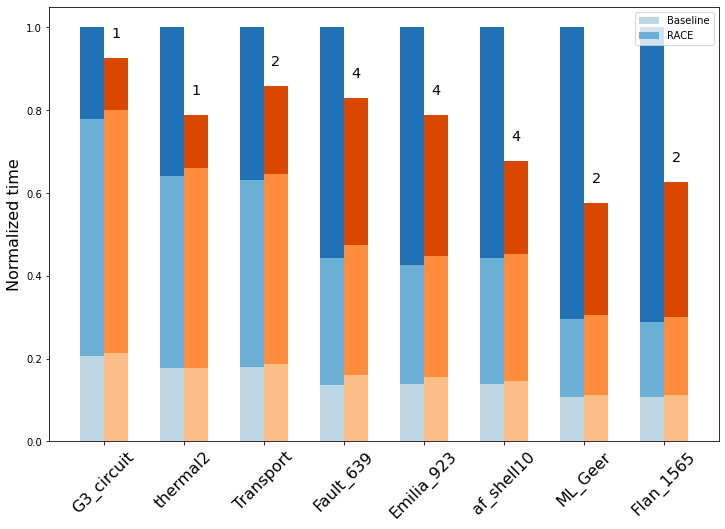

In [3]:
#plot for GMRES paper. Only performance

import operator
import math
import numpy as np

#plot for all matrix
#date="31_Aug_2022" #wo BLIS
date="6_Sept_2022" #w BLIS
#date="27_Okt_2022_avx512"
machine="tg097"
threads="64"
blis=True

BLIS_str=""
if blis:
    BLIS_str="_w_BLIS"
    
folder_wo_RACE="/Users/ud15idid/MPK_iterative_solvers/plots/"+machine+"/gmres_s_step_results"+BLIS_str+"/"+date+"/"
folder_w_RACE="/Users/ud15idid/MPK_iterative_solvers/plots/"+machine+"/gmres_s_step_results_w_RACE"+BLIS_str+"/"+date+"/"

tikzFileName="tikzOut.tex"

folders=[folder_wo_RACE, folder_w_RACE]
titles=["wo RACE", "w RACE"]
tikzFileNames=["Gmres_allMatrices_wo_RACE.tex", "Gmres_allMatrices_w_RACE.tex"]
ctr=0

#matrices=['F1', 'parabolic_fem', 'FreeBosonChain-18', 'HPCG-128-128-128', 'Geo_1438', 'FEM_3D_thermal2', 'af_shell10', 'Emilia_923', 'Transport', 'G3_circuit', 'ldoor', 'dielFilterV3real', 'ML_Geer', 'thermal2']
#matrices=['F1', 'parabolic_fem', 'HPCG-128-128-128', 'Geo_1438', 'FEM_3D_thermal2', 'af_shell10', 'Emilia_923', 'Transport', 'G3_circuit', 'ldoor', 'ML_Geer', 'thermal2']
#matrices=['G3_circuit', 'thermal2', 'af_shell7', 'Transport', 'Fault_639', 'Emilia_923', 'af_shell10',
#          'ML_Geer', 'Flan_1565']
matrices=['G3_circuit', 'thermal2', 'Transport', 'Fault_639', 'Emilia_923', 'af_shell10',
          'ML_Geer', 'Flan_1565']

restartLength='50'
otho="ICGS"
#preconType="NONE"
preconType="RELAXATION"
preconSubType="Two-stage Gauss-Seidel"
#preconSubType="Jacobi"
#preconSubType="NONE"
innerSweep="2"
RACEpower=".*"

#matrices=['ML_Geer']
#study convergence and performance
xFeature=["Matrix"]
fixedFeature={'Iter':(operator.eq,1000)} #only one feature allowed
#fixedFeature={'Iter':(operator.eq,5000), 'errNorm':(operator.le,1e-12)}
#yFeature=('errNorm', 'min') #the column and the reduction operator
yFeature="Total_time" #the column to plot
#yFeature="errNorm"
#best configuration is chosen depending on min. value of err*Solve_time 
#Note: not Total_time, because pre-processing overhead decreases with high iterations 

legendKeys=["Matrix", "Precon subtype", "ortho", 'restartLength', 'power']
#set filters

#time contributions to plot
time_contribs=["GMRES-S-STEP:Bortho", "GMRES-S-STEP:TSQR", "GMRES-S-STEP:Prec", 
                       "GMRES-S-STEP:SpMV", "GMRES-S-STEP:RACE-MPK"]

fig, axs = plt.subplots(figsize=(12, 8))
legends=['w/o RACE', 'RACE']
ctr=0

all_yData=[]
all_timeData=[]
all_chosenPower=[]
for folder in folders:
    #for rcm in ["", "_RCM"]:
    for rcm in ["", ""]:
        yData=[]
        chosenPower=[]
        timeData=[None] * len(time_contribs)
        for contribIdx in range(0,len(time_contribs)):
            timeData[contribIdx] = [] #make empty list

        matrices_w_data=[]
        #matrixNames=[]
        #find result files for matrices
        #os.chdir(folder)
        for matrix in matrices:
            matrix=matrix+rcm
            print(matrix)
            #headerFilter = {'Precon type': matrices[matrix]['Precon type'], 'Precon subtype': matrices[matrix]['Precon subtype'], 'Threads': '38', 'restartLength': matrices[matrix]['restartLength'], 'solverType': matrices[matrix]['solverType']}
            headerFilter = {'Precon type': preconType, 'Precon subtype': preconSubType, 'Threads': threads, 
                            'restartLength': restartLength, 'power': RACEpower, 'innerSweep': innerSweep}
            file=folder+matrix+".txt"
            #matrix=os.path.splitext(file)[0]
            #matrixNames.append(matrix)
            matchLineNums=find_matching_lines(file, "Matrix=")
            numMatches=len(matchLineNums)

            dfs=[]
            df_main_header_strings=[]

            for i in range(1,numMatches):
                (header, df) = pandas_read_range(file, matchLineNums[i-1], matchLineNums[i]-1)
                dfs.append(df)
                df_main_header_strings.append(header)


            #print(df_main_header_strings[20]['Matrix'])

            #df = pd.read_csv(file)
            #df.head(100)
            #dfs[0].head()


            locCtr=0
            #add totalTime to dfs
            for df in dfs:
                df['Total_time'] = df['Solve_time']+df['Precon_setup'] #+df['RACE_setup']
                if 'RACE_setup' in df.columns:
                    df['Total_time'] += df['RACE_setup']
                df['err_time_slope'] = df['errNorm'].diff()/df['Solve_time'].diff() #ranking cirteria
                #print(df['ranking_slope'])
                #print(df_main_header_strings[locCtr])
                locCtr+=1

            #now filter based on header
            matchedIdx=findMatchHeaderIds(df_main_header_strings, headerFilter);

            curYVals=[]
            timeVals=[None] * len(time_contribs)
            for contribIdx in range(0,len(time_contribs)):
                timeVals[contribIdx] = [] #make empty list

            #filter feature depending on fixedFeature and yFeature
            for feature in fixedFeature:
                featureOp=fixedFeature[feature][0]
                featureVal=fixedFeature[feature][1]

                for i in matchedIdx:
                    df=dfs[i]
                    #print(df.head())
                    filteredDf = df[featureOp(df[feature],featureVal)]
                    #print(filteredDf.head())
                    yFeatureOp=yFeature[1]
                    curYVals.extend(filteredDf[yFeature].values)
                    for contribIdx in range(0,len(time_contribs)):
                        timeVals[contribIdx].extend(filteredDf[time_contribs[contribIdx]].values)


            if (len(curYVals)!=1):
                print(curYVals)
                print("Warning: More than one matches. Taking minimum.") 

            #always take min, because it is time
            #minTime=np.min(np.array(curYVals))
            minIndex = np.argmin(np.array(curYVals))
            print("chosen index ", minIndex)
            #print("chosen rank ", curRanking[minErrIndex])
            chosen_header=df_main_header_strings[matchedIdx[minIndex]]
            print("chosen setting ", chosen_header)
            curPower=1
            if "power" in chosen_header:
                curPower=chosen_header["power"]
            print("chosen power ", curPower)
            chosenPower.append(curPower)
            print("chosen yValue ", curYVals[minIndex])
            matrices_w_data.append(matrix)
            yData.append(curYVals[minIndex])
            for contribIdx in range(0,len(time_contribs)):
                timeData[contribIdx].append(timeVals[contribIdx][minIndex])

        print(yData)
        print(timeData)
        all_yData.append(yData)
        all_timeData.append(timeData)
        all_chosenPower.append(chosenPower)
        #plt.plot(matrices_w_data, yData, '.-', label=legends[ctr])
        ctr=ctr+1

        print("matrices w data", matrices_w_data)
#yToPlot=np.array(all_yData[0])/np.array(all_yData[1])
yToPlot=[]
ctr=0
for y in all_yData[0]:
    if math.isnan(float(y)):
        all_yData[0][ctr]=np.inf
    ctr=ctr+1
ctr=0   
for y in all_yData[1]:
    if math.isnan(float(y)):
        all_yData[1][ctr]=np.inf
    ctr=ctr+1

#plt.bar(matrices_w_data, all_yData[0])
#wo_RACE_list = [plt.bar(matrices_w_data, all_yData[0], align='edge', width=-0.2)]
#w_RACE_list = [plt.bar(matrices_w_data, all_yData[1], align='edge', width=0.2)]

baseTime_wo_rcm=np.array(all_yData[0])
baseTime_w_rcm=np.array(all_yData[1])
baseTime = np.minimum(baseTime_wo_rcm, baseTime_w_rcm) #np.ones(len(all_yData[0]))
isRCMmins = (baseTime == baseTime_w_rcm)
ortho_time=np.zeros(len(baseTime_wo_rcm))
spmv_prec_time=np.zeros(len(baseTime_wo_rcm))
ctr=0
for rcmMin in isRCMmins:
    idx=0
    if rcmMin:
        idx=1
    ortho=np.array(all_timeData[idx][0])[ctr]+np.array(all_timeData[idx][1])[ctr]
    ortho_time[ctr]=ortho
    spmv_prec=np.array(all_timeData[idx][2])[ctr]+np.array(all_timeData[idx][3])[ctr]+np.array(all_timeData[idx][4])[ctr]
    spmv_prec_time[ctr]=spmv_prec
    ctr=ctr+1

misc_time=(baseTime-(ortho_time+spmv_prec_time))
        
barWidth=0.3

#normalize all time
ortho_time = ortho_time/baseTime
spmv_prec_time = spmv_prec_time/baseTime
misc_time = misc_time/baseTime

wo_RACE_list = [plt.bar(matrices_w_data, misc_time, align='edge', width=-barWidth, color="#bdd7e7"),
                plt.bar(matrices_w_data, ortho_time, bottom=misc_time, align='edge', width=-barWidth, color="#6baed6"),
                plt.bar(matrices_w_data, spmv_prec_time, bottom=(ortho_time+misc_time), align='edge', width=-barWidth, color="#2171b5")]
spmv_prec_wo_race=spmv_prec_time

#idx=1
#ortho_time=(np.array(all_timeData[idx][0])+np.array(all_timeData[idx][1]))
#spmv_prec_time=(np.array(all_timeData[idx][2])+np.array(all_timeData[idx][3])+np.array(all_timeData[idx][4]))
#misc_time=((np.array(all_yData[idx])-(ortho_time+spmv_prec_time)))
raceTime_wo_rcm=np.array(all_yData[2])
raceTime_w_rcm=np.array(all_yData[3])
raceTime = np.minimum(raceTime_wo_rcm, raceTime_w_rcm) #np.ones(len(all_yData[0]))
isRCMmins = (raceTime == raceTime_w_rcm)
ortho_time=np.zeros(len(raceTime_wo_rcm))
spmv_prec_time=np.zeros(len(raceTime_wo_rcm))
chosen_power_selected=np.zeros(len(raceTime_wo_rcm), dtype=int)

ctr=0
for rcmMin in isRCMmins:
    idx=2
    if rcmMin:
        idx=3
    ortho=np.array(all_timeData[idx][0])[ctr]+np.array(all_timeData[idx][1])[ctr]
    ortho_time[ctr]=ortho
    spmv_prec=np.array(all_timeData[idx][2])[ctr]+np.array(all_timeData[idx][3])[ctr]+np.array(all_timeData[idx][4])[ctr]
    spmv_prec_time[ctr]=spmv_prec
    chosen_power_selected[ctr] = all_chosenPower[idx][ctr]
    ctr=ctr+1
misc_time=(raceTime-(ortho_time+spmv_prec_time))
#normalize all time
ortho_time = ortho_time/baseTime
spmv_prec_time = spmv_prec_time/baseTime
misc_time = misc_time/baseTime

w_RACE_list = [plt.bar(matrices_w_data, misc_time, align='edge', width=barWidth, color="#fdbe85"),
                plt.bar(matrices_w_data, ortho_time, bottom=misc_time, align='edge', width=barWidth, color="#fd8d3c"),
                plt.bar(matrices_w_data, spmv_prec_time, bottom=(ortho_time+misc_time), align='edge', width=barWidth, color="#d94701")]
spmv_prec_w_race=spmv_prec_time

text_y_pos = np.zeros(len(w_RACE_list[2]))
ctr=0
for bars in w_RACE_list:
     ctr=0
     for bar in bars:
        text_y_pos[ctr] += bar.get_height() 
        ctr+=1

ctr=0
for bar in w_RACE_list[2]:
    plt.text(bar.get_x() + bar.get_width() / 2.0, text_y_pos[ctr] + 0.05,  chosen_power_selected[ctr], ha="center", fontsize="x-large")
    ctr+=1
        
#plt.bar(matrices_w_data, all_yData[1]) 
plt.legend(['Baseline', 'RACE'])
#axs.set_xlabel("Matrix", fontsize=16)
plt.xticks(matrices_w_data, rotation=45, fontsize=16);
axs.set_ylabel("Normalized time", fontsize=16)

#yToPlot=np.minimum(all_yData[0], all_yData[1])
print("Average MPK speedup = ", np.average(spmv_prec_wo_race/spmv_prec_w_race))
print("Average speedup = ", np.average(baseTime/raceTime))
#plt.plot(matrices_w_data, yToPlot, '.-')
#plt.plot(matrices_w_data, (np.array(all_yData[0])), '.-', label="Error norm")
tikzplotlib.save(tikzFileName)
    
#axs.set_xlabel("Matrix", fontsize=16)
#axs.set_ylabel("Time (s)", fontsize=16)
#axs.set_ylabel("Time for convergence", fontsize=16)

#axs.set_ylabel("Error norm", fontsize=16)
#axs.legend()

#axs.set_ylim([0, 1.8])


